**Summary:**

Run a single training loop using model from D4, patch from D5 and dataset from D6.

#Imports

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import os
import random
import json
import zipfile
import configparser

In [2]:
%%capture
%%bash
git clone https://github.com/yanjiekee/adversarial_ki

In [3]:
from adversarial_ki import dataset
from adversarial_ki import patch
from adversarial_ki import result

In [4]:
result.init_drive()

Mounted at /content/drive


In [5]:
!pip install kaggle

# Define username and public api key gathered from your Kaggle Account
KAGGLE_USERNAME = 'eulerismygod'
KAGGLE_PUBLIC_API_KEY = '81c12f2b229dae9c3469e25df4c04838'
api_token = {"username":KAGGLE_USERNAME,"key":KAGGLE_PUBLIC_API_KEY}

!mkdir /root/.kaggle

# Create .kaggle/kaggle.json file at the root for Kaggle API reference
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Download dataset and extract it to adversarial-person/data
!chmod 600 root/.kaggle/kaggle.json
!kaggle datasets download -d jcoral02/inriaperson

with zipfile.ZipFile('inriaperson.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/inriaperson/')

!rm inriaperson.zip

chmod: cannot access 'root/.kaggle/kaggle.json': No such file or directory
 98% 569M/582M [00:03<00:00, 148MB/s]
100% 582M/582M [00:03<00:00, 181MB/s]


In [6]:
# Clone the tensorflow models repository
%%capture
%%bash
git clone --depth 1 https://github.com/tensorflow/models
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [7]:
# Import some Object Detection API utility
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

In [8]:
%matplotlib inline

#Configuration

In [9]:
# COCO Dataset Category Index
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
CATEGORY_INDEX_COCO = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
CATEGORY_INDEX_SIZE = 90
CATEGORY_INDEX_PERSON_CLASS_ID = 1
CATEGORY_LABEL_ID_OFFSET = 1

# Dataset images
IMG_SIZE = 1024

# Loss functions definitions
RPN_LOCALISATION = "Loss/RPNLoss/localization_loss"
RPN_OBJECTNESS = "Loss/RPNLoss/objectness_loss"
CLASSIFIER_LOCALISATION = "Loss/BoxClassifierLoss/localization_loss"
CLASSIFIER_CLASSIFICATION = "Loss/BoxClassifierLoss/classification_loss"

In [10]:
# Loss dictionary reference:
# RPN_LOCALISATION
# RPN_OBJECTNESS
# CLASSIFIER_LOCALISATION
# CLASSIFIER_CLASSIFICATION

# Adversarial patch
ADV_SIZE = 100
ADV_SIZE_RANDOM = False
ADV_LOCATION_RANDOM = False
ADV_ROTATION_RANDOM = False
ADV_BRIGHTNESS_RANDOM = False

# Loss function
LOSS_FUNCTION = [CLASSIFIER_LOCALISATION, CLASSIFIER_CLASSIFICATION]
LOSS_SAMPLING_RATE = 5

# Optimiser
OPTIMISER_ALG = "sgd"

ADAM_LEARNING_RATE = 0.01
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999
ADAM_EPSILON = 1e-07
ADAM_AMSGRAD = False

SGD_LEARNING_RATE = 0.1
SGD_MOMENTUM = 0.75
SGD_NESTEROV = False

# Training size
BATCH_SIZE = 1
NUMBER_OF_ITERATION = 10000
NUMBER_OF_EPOCH = 1

# Learning rate scheduler
SCHEDULER_ALG = "polynomial_decay"

POLY_SCH_INITIAL_LEARNING_RATE = 100.0
POLY_SCH_DECAY_STEPS = NUMBER_OF_ITERATION * NUMBER_OF_EPOCH
POLY_SCH_END_LEARNING_RATE = 0.0001
POLY_SCH_POWER = 0.5
POLY_SCH_CYCLE = False

#Adversarial Patch

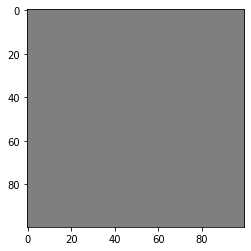

In [11]:
# Initialise a grey adversarial patch
init_patch = patch.init(random=False)
adversarial_patch = tf.Variable(
    initial_value=init_patch,
    trainable=True,
    dtype=tf.float32
)

# Keep a copy of the initial adversarial patch
adversarial_patch_init = init_patch.numpy()

plt.imshow(adversarial_patch_init[0])

#Debug

In [12]:
def filter_dataset_files(dir):
  """Remove part of the dataset files for quicker debug
  """
  directory = os.fsencode(dir)
  for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if not filename.startswith("person_and_bike"):
      os.remove(os.path.join(dir, filename))
      continue
    else:
      continue

#Utilities

In [13]:
def plot_detections(img, boxes, classes, scores, category_index, size=(6, 6), threshold=0.8):
  """Wrapper function for visualize_boxes_and_labels_on_image_array"""
  image_np_with_annotations = img.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  
  plt.figure(figsize=size)
  plt.imshow(image_np_with_annotations)

In [14]:
def dataset_sanity_check(img_list_ts, box_list_np, class_list_np, category_index, index=None):

  print("Image list length:   ", len(img_list_ts))
  print("Boxes list length:   ", len(box_list_np))
  print("Classes list length: ", len(class_list_np))

  length = len(img_list_ts)

  if index is None:
    index = random.randrange(length)
  elif index >= length:
    print("WARNING: Index is out of range, random index is assigned.")
    index = random.randrange(length)

  img = img_list_ts[index].numpy().astype(np.int32)[0]
  boxes = box_list_np[index]
  classes = class_list_np[index].astype(np.uint32)
  scores = np.ones(shape=(len(classes)))

  plot_detections(img, boxes, classes, scores, category_index)

In [15]:
def detection_model_sanity_check(model, img_list_ts, category_index, index=None):
  """Plot the detection boxes of a selected image
  """

  if index is None:
    index = random.randrange(len(img_list_ts))
  elif index >= len(img_list_ts):
    print("WARNING: Index is out of range, random index is assigned.")
    index = random.randrange(len(img_list_ts))

  index = random.randrange(len(img_list_ts))
  img = img_list_ts[index].numpy().astype(np.uint32)[0]

  detections = detect(img_list_ts[index])

  plot_detections(
      img,
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + CATEGORY_LABEL_ID_OFFSET,
      detections['detection_scores'][0].numpy(),
      category_index)

In [16]:
def result_sanity_check(model, img_list_ts, adv_box_ts, adv_patch, category_index, index=None, threshold=0.8):
  """Verify adversarial patch by comparing the before and after adversarial
  patch is attached to an image
  """

  if index is None:
    index = random.randrange(len(img_list_ts))
  elif index >= len(img_list_ts):
    print("WARNING: Index is out of range, random index is assigned.")
    index = random.randrange(len(img_list_ts))

  img = img_list_ts[index].numpy().astype(np.uint32)[0]

  # Before
  detections = detect(img_list_ts[index])
  
  plot_detections(
      img,
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + CATEGORY_LABEL_ID_OFFSET,
      detections['detection_scores'][0].numpy(),
      category_index,
      size=(20,20))
  
  # After
  adv_mask = patch.transform(adv_box_ts[index], tf.multiply(adv_patch, 255.0))
  adv_img = tf.clip_by_value(patch.apply(img_list_ts[index], adv_mask), 0, 255)
  detections = detect(adv_img)

  plot_detections(
      adv_img.numpy().astype(int)[0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + CATEGORY_LABEL_ID_OFFSET,
      detections['detection_scores'][0].numpy(),
      category_index,
      size=(20,20),
      threshold=threshold)

#Model

In [17]:
# Model selection
MODEL_NAME_LIST = [
                   'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8',
                   'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8',
                   'faster_rcnn_resnet50_v1_800x1333_coco17_gpu-8',
                   'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8',
                   'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8',
                   'faster_rcnn_resnet101_v1_800x1333_coco17_gpu-8'
]

In [18]:
def download_model(model_name, model_date):
  """Downloaded files are stored in Keras cache"""
  base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(fname=model_name,
                                      origin=base_url + model_date + '/' + model_file,
                                      untar=True)
  return str(model_dir)

# Download and extract model
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
MODEL_DATE = '20200711'
MODEL_NAME = 'faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

# Load pipeline config and build a detection model
PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"

configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

353902592/353893393 [==============================] - 2s 0us/step


In [19]:
# Create a graph execution for faster future use
@tf.function
def detect(input_tensor):
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

#Dataset

In [20]:
# Dateset directories
test_img_dir = '/content/data/inriaperson/Test/JPEGImages'

# Filter dataset files (DEBUG)
filter_dataset_files(test_img_dir)

# Fetch dataset
test_img_np = dataset.fetch(test_img_dir)

# Tensorfy images
test_img_ts = dataset.tensorfy_and_resize_img(test_img_np, IMG_SIZE)

# Label dataset
label_dataset_fn = dataset.get_label_dataset_fn(detection_model, IMG_SIZE)
test_box_np, test_class_np = label_dataset_fn(test_img_ts)

# Filter dataset
test_img_ts, test_box_np, test_class_np = dataset.filter_no_person(test_img_ts, test_box_np, test_class_np, CATEGORY_INDEX_PERSON_CLASS_ID)
test_img_ts, test_box_np, test_class_np = dataset.filter_multiple_person(test_img_ts, test_box_np, test_class_np, CATEGORY_INDEX_PERSON_CLASS_ID)
test_img_ts, test_box_np, test_class_np = dataset.filter_single_detection(test_img_ts, test_box_np, test_class_np)

# Generate mallicious groundtruths
test_mal_box_np, test_mal_class_np, test_adv_box_np = dataset.generate_mallicious_objectness_gt(test_box_np, test_class_np, CATEGORY_INDEX_PERSON_CLASS_ID)

# Tensorfy groundtruths
test_mal_box_ts, test_mal_class_ts, test_adv_box_ts = dataset.tensorfy_gt(test_mal_box_np, test_mal_class_np, test_adv_box_np, CATEGORY_INDEX_SIZE)

INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.


Image list length:    76
Boxes list length:    76
Classes list length:  76


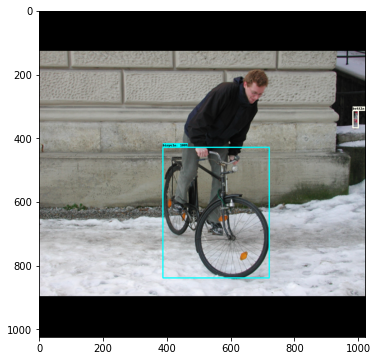

In [21]:
dataset_sanity_check(test_img_ts, test_mal_box_np, test_mal_class_np, CATEGORY_INDEX_COCO)

#Training Init



In [22]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, training_var):
  """Get a tf.function for training step."""

  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list,
                    targeted_box):
    """A single training iteration.

    Args:
      image_tensors: A [1, height, width, 3] Tensor of type tf.float32.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type tf.float32
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes] with type tf.float32
      targeted_box: A Tensor of shape [1, 4] with type tf.float32

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    
    with tf.GradientTape() as tape:

      tape.watch(training_var)

      #NOTE: Assumption - image tensors only contain single image tensor
      adv_mask = patch.transform(box=targeted_box, 
                                 patch=training_var,
                                 mask_width=tf.constant(IMG_SIZE, tf.float32),
                                 random_size=tf.constant(ADV_SIZE_RANDOM, tf.bool),
                                 random_location=tf.constant(ADV_LOCATION_RANDOM, tf.bool))

      preprocessed_images, shapes = model.preprocess(image_tensors)
      preprocessed_adv_images = patch.apply(preprocessed_images, adv_mask)
      prediction_dict = model.predict(preprocessed_adv_images, shapes)

      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict[CLASSIFIER_CLASSIFICATION] + losses_dict[CLASSIFIER_LOCALISATION]

      gradients = tape.gradient(total_loss, training_var)

      #DEBUG
      tf.print(gradients)

      # Convert 'gradients' and 'training_variable' as list perhaps because it's
      # tape.gradient() don't return gradient when a batch size of one is given to
      # the detector model for prediction
      # optimizer.apply_gradients(zip([gradients], [training_var]))

      # Clip value to valid RGB
      training_var.assign(tf.clip_by_value(training_var, clip_value_min=0, clip_value_max=1))

    return total_loss

  return train_step_fn

In [23]:
# Get training step
training_variable = adversarial_patch

if OPTIMISER_ALG == "adam":
  optimiser = tf.keras.optimizers.Adam(
      learning_rate=ADAM_LEARNING_RATE,
      beta_1=ADAM_BETA_1,
      beta_2=ADAM_BETA_2,
      epsilon=ADAM_EPSILON,
      amsgrad=ADAM_AMSGRAD,
  )
elif OPTIMISER_ALG == "sgd":

  if SCHEDULER_ALG == None:
    learning_rate=SGD_LEARNING_RATE

  elif SCHEDULER_ALG == "polynomial_decay":
    learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=POLY_SCH_INITIAL_LEARNING_RATE,
        decay_steps=POLY_SCH_DECAY_STEPS,
        end_learning_rate=POLY_SCH_END_LEARNING_RATE,
        power=POLY_SCH_POWER,
        cycle=POLY_SCH_CYCLE
    )

  optimiser = tf.keras.optimizers.SGD(
      learning_rate=learning_rate,
      momentum=SGD_MOMENTUM,
      nesterov=SGD_NESTEROV
  )

train_step_fn = get_model_train_step_function(detection_model, optimiser, training_variable)

Image list length:    76
Boxes list length:    76
Classes list length:  76


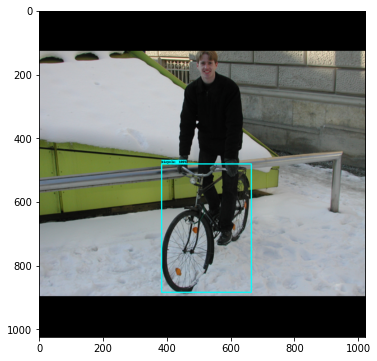

In [24]:
# Take one sample from training dataset
sample_id = 1
sample_img = test_img_ts[sample_id]
sample_mal_box = [test_mal_box_ts[sample_id]]
sample_mal_class = [test_mal_class_ts[sample_id]]
sample_adv_box = test_adv_box_ts[sample_id]

dataset_sanity_check(test_img_ts, test_mal_box_np, test_mal_class_np, CATEGORY_INDEX_COCO, index=sample_id)

#Training Loop

In [25]:
import time
import datetime

# Run training
loss_history = []
start = time.process_time()

for i in range(NUMBER_OF_ITERATION):
  loss = train_step_fn(sample_img, sample_mal_box, sample_mal_class, sample_adv_box)

  if i % LOSS_SAMPLING_RATE == 0:
    loss_history.append(loss.numpy())

  if i % 1000 == 999:
    ct = datetime.datetime.now()
    time_taken = time.process_time() - start
    seconds_remaining = time_taken / i * (NUMBER_OF_ITERATION-i)
    mins_remaining = int(seconds_remaining / 60)
    print('round=' + str(i) + ', loss=' +  str(loss.numpy()), flush=True)
    print('time=' + str(ct.hour) + ':' + str(ct.minute) + ', estimated time remaining= ' + str(mins_remaining) + ' min\n', flush=True)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/ClipToWindow/Gather/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/ClipToWindow/Slice_1:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/ClipToWindow/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/BatchMultiClassNonMaxSuppression/MultiClassNonMaxSuppression/ClipToWindow/Gather

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


KeyboardInterrupt: ignored

#Result

In [ ]:
result_dir = result.init()

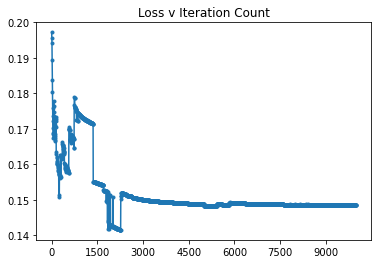

In [ ]:
result_dir = result.new_record('/content/drive/MyDrive/Adversarial/results')

config = configparser.ConfigParser()

config['ADV_PATCH'] = {}
adv_config = config['ADV_PATCH']
adv_config['SIZE'] = str(ADV_SIZE)
adv_config['SIZE_RANDOM'] = str(ADV_SIZE_RANDOM)
adv_config['LOCATION_RANDOM'] = str(ADV_LOCATION_RANDOM)
adv_config['ROTATION_RANDOM'] = str(ADV_ROTATION_RANDOM)
adv_config['BRIGHTNESS_RANDOM'] = str(ADV_BRIGHTNESS_RANDOM)

config['LOSS_FUNC'] = {}
loss_config = config['LOSS_FUNC']
loss_config['TYPE'] = str(LOSS_FUNCTION)
loss_config['SAMPLING_RATE'] = str(LOSS_SAMPLING_RATE)

config['OPTIMISER'] = {}
optimiser_config = config['OPTIMISER']
if OPTIMISER_ALG == "adam":
  optimiser_config['ADAM_LEARNING_RATE'] = str(ADAM_LEARNING_RATE)
  optimiser_config['ADAM_BETA_1'] = str(ADAM_BETA_1)
  optimiser_config['ADAM_BETA_2'] = str(ADAM_BETA_2)
  optimiser_config['ADAM_EPSILON'] = str(ADAM_EPSILON)
  optimiser_config['ADAM_AMSGRAD'] = str(ADAM_AMSGRAD)
elif OPTIMISER_ALG == "sgd":
  if SCHEDULER_ALG == None:
    optimiser_config['SGD_LEARNING_RATE'] = str(SGD_LEARNING_RATE)
  optimiser_config['SGD_MOMENTUM'] = str(SGD_MOMENTUM)
  optimiser_config['SGD_NESTEROV'] = str(SGD_NESTEROV)

if SCHEDULER_ALG != None:
  config['SCHEDULER'] = {}
  scheduler_config = config['SCHEDULER']
  if SCHEDULER_ALG == "polynomial_decay":
    scheduler_config['POLY_SCH_INITIAL_LEARNING_RATE'] = str(POLY_SCH_INITIAL_LEARNING_RATE)
    scheduler_config['POLY_SCH_DECAY_STEPS'] = str(POLY_SCH_DECAY_STEPS)
    scheduler_config['POLY_SCH_END_LEARNING_RATE'] = str(POLY_SCH_END_LEARNING_RATE)
    scheduler_config['POLY_SCH_POWER'] = str(POLY_SCH_POWER)
    scheduler_config['POLY_SCH_CYCLE'] = str(POLY_SCH_CYCLE)

config['TRAINING_LOOP'] = {}
training_loop_config = config['TRAINING_LOOP']
training_loop_config['BATCH_SIZE'] = str(BATCH_SIZE)
training_loop_config['NUMBER_OF_ITERATION'] = str(NUMBER_OF_ITERATION)
training_loop_config['NUMBER_OF_EPOCH'] = str(NUMBER_OF_EPOCH)

with open(result_dir + '/training.ini', 'w') as configfile:
  config.write(configfile)

result.store_adv_checkpoint(adversarial_patch, result_dir)
result.store_loss_history_csv(loss_history, LOSS_SAMPLING_RATE, result_dir)
result.print_and_save_loss_history_plot(loss_history, LOSS_SAMPLING_RATE, result_dir)

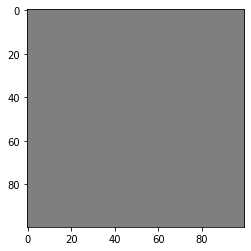

In [ ]:
plt.imshow(adversarial_patch_init[0])

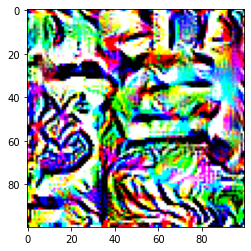

In [ ]:
plt.imshow(adversarial_patch.numpy()[0])

In [ ]:
result_sanity_check(detection_model, 
                    test_img_ts, 
                    test_adv_box_ts, 
                    adversarial_patch,
                    CATEGORY_INDEX_COCO, 
                    index=sample_id,
                    threshold=0.8)

Output hidden; open in https://colab.research.google.com to view.